In [58]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from fbprophet import Prophet
from datetime import datetime
from numpy import array
from numpy import split
import matplotlib.pyplot as plt

In [59]:
timestr = time.strftime("%Y_%m_%d")
timestr = '2020_04_14'
df = pd.read_csv(r'..\..\data\dev_data\covid19_time_series_{}.csv'.format(timestr))
##Active is always zero...manually correct via simple calculation
df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']

## Multiple Linear Regression Approach

In [136]:
## really only need the date and confirmed columns but bringing along the other in case we want to predict any of them
country_df_regres = df.groupby(['Country','Date']).sum()[["Confirmed","Recovered","Active","Deaths"]].reset_index()

In [137]:
global_df = country_df_regres.groupby('Date').sum()[["Confirmed","Recovered","Active","Deaths"]].reset_index()
global_df['Date'] = pd.to_datetime(global_df['Date'])

In [161]:
mlr_global_df = global_df.copy()

In [162]:
## create lag variables from the last two weeks
for i in range(7, 15):
    mlr_global_df[f'Confirmed_lag_{i}'] = mlr_global_df['Confirmed'].shift(i)
    mlr_global_df[f'Deaths_lag_{i}'] = mlr_global_df['Deaths'].shift(i)
    mlr_global_df[f'Recovered_lag_{i}'] = mlr_global_df['Recovered'].shift(i)
    mlr_global_df[f'Active_lag{i}'] = mlr_global_df['Active'].shift(i)

In [163]:
mlr_global_df.head()

,Date,Confirmed,Recovered,Active,Deaths,Confirmed_lag_7,Deaths_lag_7,Recovered_lag_7,Active_lag7,Confirmed_lag_8,...,Recovered_lag_12,Active_lag12,Confirmed_lag_13,Deaths_lag_13,Recovered_lag_13,Active_lag13,Confirmed_lag_14,Deaths_lag_14,Recovered_lag_14,Active_lag14
0,2020-01-22 00:00:00+00:00,554,28,509,17,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-23 00:00:00+00:00,654,30,606,18,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-24 00:00:00+00:00,941,36,879,26,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-25 00:00:00+00:00,1434,39,1353,42,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-26 00:00:00+00:00,2118,52,2010,56,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
mlr_global_df_use = mlr_global_df.dropna()

### First model just using the confirmed cases lag columns

In [165]:
mlr_global_df_use=mlr_global_df_use.reset_index()
lag_cols_only =  [col for col in mlr_global_df_use.columns if 'Confirmed_lag_' in col]
X = mlr_global_df_use[lag_cols_only]
y = mlr_global_df_use['Confirmed']

In [166]:
num_in_test = 7
test_size = float(num_in_test) / len(X)
n_splits = int((1//test_size)-1)
tscv = TimeSeriesSplit(n_splits=n_splits)

In [167]:
y_preds = []
mapes =  []
model_coefs = []
first_test_ind = 50000
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    if test_index[0] < first_test_ind:
        first_test_ind=test_index[0]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    model_coefs.append(model.coef_)
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    y_preds.append(y_pred)
    mapes.append(round((abs((y_pred -y_test) / y_test) * 100).mean()))
    

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] TEST: [55 56 57 58 59 60 61]
TRAIN: [ 0  1 

In [168]:
np.mean(mapes)

16.625

No handles with labels found to put in legend.


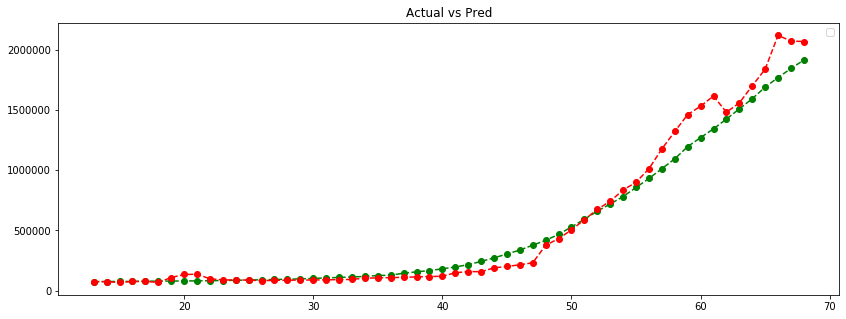

In [169]:
fig, ax = plt.subplots(figsize=(14, 5))
y_preds = [y for x in y_preds for y in x]
yplot = y[first_test_ind:]
ax.plot(yplot, 'go--')
ax.plot(pd.Series(y_preds, index = yplot.index), 'ro--')

plt.title('Actual vs Pred')
plt.legend()
plt.show()

### Next linear regression model with some engineered features

In [71]:
cols=['Date','Confirmed']
lag_cols = [col for col in mlr_global_df.columns if 'Confirmed_lag_' in col]
train_cols=cols+lag_cols
mlr_conf_global_df  = mlr_global_df[train_cols]
mlr_conf_global_df['month']=mlr_conf_global_df['Date'].dt.month 
mlr_conf_global_df['dayofweek']=mlr_conf_global_df['Date'].dt.dayofweek
#mlr_conf_global_df['seven_day_rolling_mean_confirmed'] = mlr_conf_global_df['Confirmed'].rolling(window=7).mean()
#weights = np.arange(1,8)
#mlr_conf_global_df['wgtd_seven_day_rolling_mean_confirmed'] = mlr_conf_global_df['Confirmed'].rolling(window=7).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
mlr_conf_global_df = mlr_conf_global_df.dropna()

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
X = mlr_conf_global_df.drop(columns=['Confirmed','Date'])
y = mlr_conf_global_df['Confirmed']

In [74]:
y_preds2 = []
mapes2 =  []
model_coefs2 = []
first_test_ind2 = 50000
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    if test_index[0] < first_test_ind2:
        first_test_ind2=test_index[0]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    model_coefs2.append(model.coef_)
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    y_preds2.append(y_pred)
    mapes2.append(round((abs((y_pred -y_test) / y_test) * 100).mean()))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] TEST: [55 56 57 58 59 60 61]
TRAIN: [ 0  1 

In [75]:
np.mean(mapes2)

17.0

No handles with labels found to put in legend.


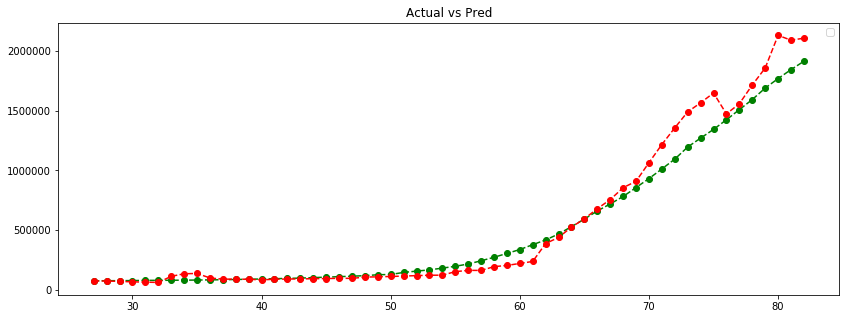

In [76]:
fig, ax = plt.subplots(figsize=(14, 5))
y_preds2 = [y for x in y_preds2 for y in x]
yplot = y[first_test_ind2:]
ax.plot(yplot, 'go--')
ax.plot(pd.Series(y_preds2, index = yplot.index), 'ro--')

plt.title('Actual vs Pred')
plt.legend()
plt.show()

In [77]:
X.columns

Index(['Confirmed_lag_7', 'Confirmed_lag_8', 'Confirmed_lag_9',
       'Confirmed_lag_10', 'Confirmed_lag_11', 'Confirmed_lag_12',
       'Confirmed_lag_13', 'Confirmed_lag_14', 'month', 'dayofweek'],
      dtype='object')

In [78]:
model_coefs2

[array([-2.08452294e-01, -1.32476836e-01,  1.15456485e-01,  4.02230544e-01,
         3.65756740e+00,  9.65962580e-01, -2.80926097e+00, -1.49113995e+00,
         0.00000000e+00, -4.35647368e+02]),
 array([ 0.06733918,  0.04743474,  0.2102252 ,  0.04468243,  0.67646832,
         3.5126412 , -1.39283626, -2.50867979,  0.        , 39.34195713]),
 array([ 8.32510546e-01, -2.20456149e-01,  2.61119511e-01, -7.31188684e-02,
         3.77903304e-01, -1.35212788e-01,  1.82188895e-01, -5.96641689e-01,
         7.76328600e+03,  3.95437164e+02]),
 array([ 9.71920219e-01, -2.71243636e-01,  2.25495859e-01, -9.17554669e-02,
         3.60839434e-01, -1.89794723e-01,  1.16280624e-01, -4.73030578e-01,
         1.47579000e+04,  3.87928073e+02]),
 array([ 2.07529986e+00, -5.10101075e-01,  2.14038329e-01, -2.16716754e-01,
         1.23139179e-01, -3.14498997e-01,  1.60492752e-01, -8.15075153e-01,
         3.00677258e+04,  3.39649144e+02]),
 array([ 4.61724881e+00, -5.06613249e-01, -2.14192003e-01, -7.123344

In [79]:
mlr_conf_global_df

,Date,Confirmed,Confirmed_lag_7,Confirmed_lag_8,Confirmed_lag_9,Confirmed_lag_10,Confirmed_lag_11,Confirmed_lag_12,Confirmed_lag_13,Confirmed_lag_14,month,dayofweek
14,2020-02-05 00:00:00+00:00,27635,6166.0,5578.0,2927.0,2118.0,1434.0,941.0,654.0,554.0,2,2
15,2020-02-06 00:00:00+00:00,30794,8234.0,6166.0,5578.0,2927.0,2118.0,1434.0,941.0,654.0,2,3
16,2020-02-07 00:00:00+00:00,34330,9927.0,8234.0,6166.0,5578.0,2927.0,2118.0,1434.0,941.0,2,4
17,2020-02-08 00:00:00+00:00,37059,12038.0,9927.0,8234.0,6166.0,5578.0,2927.0,2118.0,1434.0,2,5
18,2020-02-09 00:00:00+00:00,40086,16787.0,12038.0,9927.0,8234.0,6166.0,5578.0,2927.0,2118.0,2,6
19,2020-02-10 00:00:00+00:00,42627,19881.0,16787.0,12038.0,9927.0,8234.0,6166.0,5578.0,2927.0,2,0
20,2020-02-11 00:00:00+00:00,44667,23892.0,19881.0,16787.0,12038.0,9927.0,8234.0,6166.0,5578.0,2,1
21,2020-02-12 00:00:00+00:00,45046,27635.0,23892.0,19881.0,16787.0,12038.0,9927.0,8234.0,6166.0,2,2
22,2020-02-13 00:00:00+00:00,60193,30794.0,27635.0,23892.0,19881.0,16787.0,12038.0,9927.0,8234.0,2,3
23,2020-02-14 00:00:00+00:00,66667,34330.0,30794.0,27635.0,23892.0,19881.0,16787.0,12038.0,9927.0,2,4


### Use  model to predict two weeks out

In [82]:
num_in_test = 14
test_size = float(num_in_test) / len(X)
n_splits = int((1//test_size)-1)
tscv = TimeSeriesSplit(n_splits=n_splits)

X = mlr_global_df_use[lag_cols_only]
y = mlr_global_df_use['Confirmed']
y_preds3 = []
mapes3 =  []
model_coefs3 = []
first_test_ind3 = 50000
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    if test_index[0] < first_test_ind3:
        first_test_ind3=test_index[0]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    model_coefs3.append(model.coef_)
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    y_preds3.append(y_pred)
    mapes3.append(round((abs((y_pred -y_test) / y_test) * 100).mean()))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34] TEST: [35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51] TEST: [52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]


In [83]:
np.mean(mapes3)

29.0

No handles with labels found to put in legend.


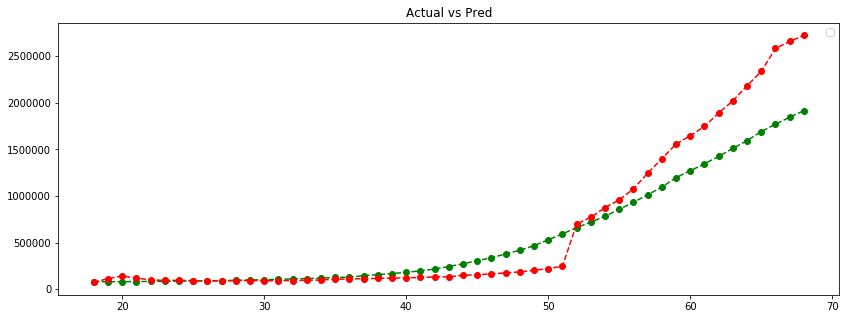

In [84]:
fig, ax = plt.subplots(figsize=(14, 5))
y_preds3 = [y for x in y_preds3 for y in x]
yplot = y[first_test_ind3:]
ax.plot(yplot, 'go--')
ax.plot(pd.Series(y_preds3, index = yplot.index), 'ro--')

plt.title('Actual vs Pred')
plt.legend()
plt.show()

In [85]:
comparison_df = pd.DataFrame([yplot.values,y_preds3]).transpose()
comparison_df.rename(columns={0:'Actual',1:'Forecasted'},inplace=True)
comparison_df['abs_resid'] = comparison_df['Actual']-comparison_df['Forecasted']
comparison_df['Percent Error'] = 100*(comparison_df['Actual']-comparison_df['Forecasted'])/comparison_df['Actual']

In [86]:
comparison_df.style.format("{:.1f}")

,Actual,Forecasted,abs_resid,Percent Error
0,78267.0,71480.0,6787.0,8.7
1,78834.0,112963.0,-34129.0,-43.3
2,79679.0,139899.0,-60220.0,-75.6
3,80641.0,119528.0,-38887.0,-48.2
4,81999.0,98081.0,-16082.0,-19.6
5,83363.0,94189.0,-10826.0,-13.0
6,85262.0,94531.0,-9269.0,-10.9
7,87620.0,90843.0,-3223.0,-3.7
8,89556.0,87331.0,2225.0,2.5
9,92089.0,86728.0,5361.0,5.8


### Holt Linear Model

In [87]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [88]:
X = mlr_global_df_use[lag_cols_only]
y = mlr_global_df_use['Confirmed']

In [89]:
num_in_test = 7
test_size = float(num_in_test) / len(X)
n_splits = int((1//test_size)-1)
tscv = TimeSeriesSplit(n_splits=n_splits)

In [90]:
y_preds_holt = []
mapes_holt =  []
first_test_ind_holt=500000
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    if test_index[0] < first_test_ind_holt:
        first_test_ind_holt=test_index[0]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    holtfit = ExponentialSmoothing(y_train, trend='mul',seasonal=None,damped=True).fit()
    y_pred = holtfit.forecast(7)
    y_preds_holt.append(np.round(y_pred.values))
    mapes_holt.append(round((abs((y_pred.values -y_test) / y_test) * 100).mean()))
    

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]


C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal



TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] TEST: [55 56 57 58 59 60 61]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61] TEST: [62 63 64 65 66 67 68]


In [91]:
np.mean(mapes_holt)

8.25

No handles with labels found to put in legend.


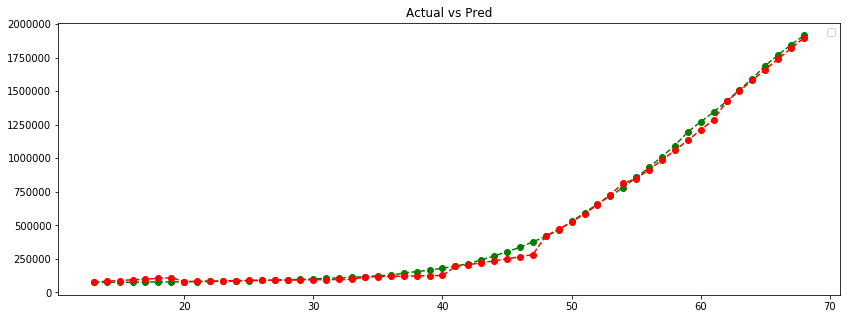

In [92]:
fig, ax = plt.subplots(figsize=(14, 5))
y_preds_holt_plot = [y for x in y_preds_holt for y in x]
yplot = y[first_test_ind_holt:]
ax.plot(yplot, 'go--')
ax.plot(pd.Series(y_preds_holt_plot, index = yplot.index), 'ro--')

plt.title('Actual vs Pred')
plt.legend()
plt.show()

### holt 2 week

In [93]:
num_in_test = 14
test_size = float(num_in_test) / len(X)
n_splits = int((1//test_size)-1)
tscv = TimeSeriesSplit(n_splits=n_splits)

y_preds_holt_2wk = []
mapes_holt_2wk =  []
first_test_ind_holt_2wk=500000
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    if test_index[0] < first_test_ind_holt_2wk:
        first_test_ind_holt_2wk=test_index[0]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    holtfit_2wk = ExponentialSmoothing(y_train, trend='mul',seasonal=None,damped=True).fit()
    y_pred = holtfit_2wk.forecast(len(y_test))
    y_preds_holt_2wk.append(np.round(y_pred.values))
    mapes_holt_2wk.append(round((abs((y_pred.values -y_test) / y_test) * 100).mean()))
    

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34] TEST: [35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51]


C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal



TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51] TEST: [52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]


In [94]:
np.mean(mapes_holt_2wk)

30.666666666666668

No handles with labels found to put in legend.


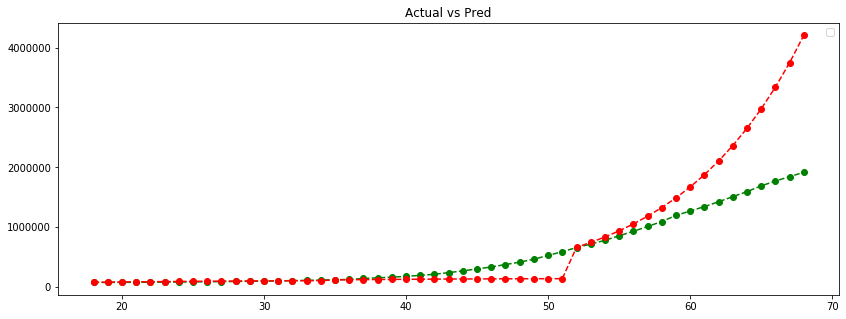

In [95]:
fig, ax = plt.subplots(figsize=(14, 5))
y_preds_holt_2wk_plot = [y for x in y_preds_holt_2wk for y in x]
yplot = y[first_test_ind_holt_2wk:]
ax.plot(yplot, 'go--')
ax.plot(pd.Series(y_preds_holt_2wk_plot, index = yplot.index), 'ro--')

plt.title('Actual vs Pred')
plt.legend()
plt.show()

### ARIMA Model

In [96]:
from statsmodels.tsa.arima_model import ARIMA

In [97]:
y = mlr_global_df_use['Confirmed']
num_in_test = 7
test_size = float(num_in_test) / len(X)
n_splits = int((1//test_size)-1)
tscv = TimeSeriesSplit(n_splits=n_splits)
y_preds_arima = []
mapes_arima =  []
first_test_ind=500000
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    if test_index[0] < first_test_ind:
        first_test_ind=test_index[0]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    model_arima=ARIMA(y_train,(1,1,0))
    model_arima_fit=model_arima.fit()
    y_pred = model_arima_fit.forecast(len(y_test))[0]
    y_preds_arima.append(np.round(y_pred))
    mapes_arima.append(round((abs((y_pred -y_test) / y_test) * 100).mean()))
    

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] TEST: [55 56 57 58 59 60 61]
TRAIN: [ 0  1 

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



In [98]:
np.mean(mapes_arima)

9.75

In [111]:
def evaluate_models(timeseries_data,p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mape = evaluate_arima_model(timeseries_data,order)
                    if mape < best_score:
                        best_score, best_cfg = mape, order
                    print('ARIMA%s MSE=%.3f' % (order,mape))
                except:
                    continue
    print('Best ARIMA%s MAPE=%.3f' % (best_cfg, best_score))

In [112]:
def evaluate_arima_model(timeseries_data,arima_order):
    # prepare training dataset
    
    y = timeseries_data
    num_in_test = 7
    test_size = float(num_in_test) / len(X)
    n_splits = int((1//test_size)-1)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    y_preds_arima = []
    mapes_arima =  []
    
    for train_index, test_index in tscv.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        model_arima=ARIMA(y_train,arima_order)
        model_arima_fit=model_arima.fit()
        y_pred = model_arima_fit.forecast(len(y_test))[0]
        y_preds_arima.append(np.round(y_pred))
        mapes_arima.append(round((abs((y_pred -y_test) / y_test) * 100).mean()))
    
    return np.mean(mapes_arima)

In [113]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3) #this is the range for the values
q_values = range(0, 3) #this is the range for the values

In [114]:
evaluate_models(y, p_values, d_values, q_values)

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54]


C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmode

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] TEST: [55 56 57 58 59 60 61]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61] TEST: [62 63 64 65 66 67 68]
ARIMA(0, 0, 1) MSE=54.125
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] TEST: [55 56 57 58 59 60 61]


C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61] TEST: [62 63 64 65 66 67 68]
ARIMA(0, 0, 2) MSE=51.000
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning:

invalid value encountered in add

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] TEST: [55 56 57 58 59 60 61]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 2

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] TEST: [55 56 57 58 59 60 61]


C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61] TEST: [62 63 64 65 66 67 68]
ARIMA(1, 1, 0) MSE=9.750
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 4

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] TEST: [55 56 57 58 59 60 61]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 2

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]


C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] TEST: [55 56 57 58 59 60 61]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 2

In [99]:
y = mlr_global_df_use['Confirmed']
num_in_test = 7
test_size = float(num_in_test) / len(X)
n_splits = int((1//test_size)-1)
tscv = TimeSeriesSplit(n_splits=n_splits)
y_preds_arima = []
mapes_arima =  []
first_test_ind=500000
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    if test_index[0] < first_test_ind:
        first_test_ind=test_index[0]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    model_arima=ARIMA(y_train,(2,2,0))
    model_arima_fit=model_arima.fit()
    y_pred = model_arima_fit.forecast(len(y_test))[0]
    y_preds_arima.append(np.round(y_pred))
    mapes_arima.append(round((abs((y_pred -y_test) / y_test) * 100).mean()))
    

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] TEST: [55 56 57 58 59 60 61]
TRAIN: [ 0  1 

In [100]:
np.mean(mapes_arima)

6.25

No handles with labels found to put in legend.


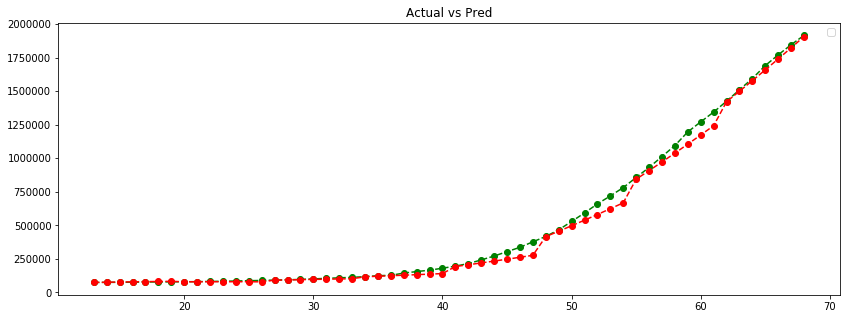

In [101]:
fig, ax = plt.subplots(figsize=(14, 5))
y_preds_arima_plot = [y for x in y_preds_arima for y in x]
yplot = y[first_test_ind:]
ax.plot(yplot, 'go--')
ax.plot(pd.Series(y_preds_arima_plot, index = yplot.index), 'ro--')

plt.title('Actual vs Pred')
plt.legend()
plt.show()

### ARIMA Two Weeks

In [119]:
y = mlr_global_df_use['Confirmed']
num_in_test = 14
test_size = float(num_in_test) / len(X)
n_splits = int((1//test_size)-1)
tscv = TimeSeriesSplit(n_splits=n_splits)
y_preds_arima = []
mapes_arima =  []
first_test_ind=500000
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    if test_index[0] < first_test_ind:
        first_test_ind=test_index[0]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    model_arima=ARIMA(y_train,(2,2,0))
    model_arima_fit=model_arima.fit()
    y_pred = model_arima_fit.forecast(len(y_test))[0]
    y_preds_arima.append(np.round(y_pred))
    mapes_arima.append(round((abs((y_pred -y_test) / y_test) * 100).mean()))
    

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34] TEST: [35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51] TEST: [52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]


In [120]:
np.mean(mapes_arima)

16.0

No handles with labels found to put in legend.


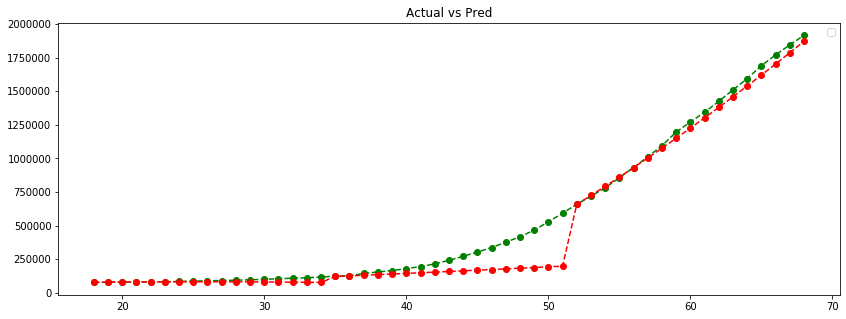

In [121]:
fig, ax = plt.subplots(figsize=(14, 5))
y_preds_arima_plot = [y for x in y_preds_arima for y in x]
yplot = y[first_test_ind:]
ax.plot(yplot, 'go--')
ax.plot(pd.Series(y_preds_arima_plot, index = yplot.index), 'ro--')

plt.title('Actual vs Pred')
plt.legend()
plt.show()

In [122]:
### ARIMA 10 Day

In [123]:
y = mlr_global_df_use['Confirmed']
num_in_test = 10
test_size = float(num_in_test) / len(X)
n_splits = int((1//test_size)-1)
tscv = TimeSeriesSplit(n_splits=n_splits)
y_preds_arima = []
mapes_arima =  []
first_test_ind=500000
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    if test_index[0] < first_test_ind:
        first_test_ind=test_index[0]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    model_arima=ARIMA(y_train,(2,2,0))
    model_arima_fit=model_arima.fit()
    y_pred = model_arima_fit.forecast(len(y_test))[0]
    y_preds_arima.append(np.round(y_pred))
    mapes_arima.append(round((abs((y_pred -y_test) / y_test) * 100).mean()))
    

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14 15 16 17 18 19 20 21 22 23 24]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] TEST: [25 26 27 28 29 30 31 32 33 34 35]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] TEST: [36 37 38 39 40 41 42 43 44 45 46]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] TEST: [47 48 49 50 51 52 53 54 55 56 57]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57] TEST: [58 59 60 61 62 63 64 65 66 67 68]


In [124]:
np.mean(mapes_arima)

9.8

No handles with labels found to put in legend.


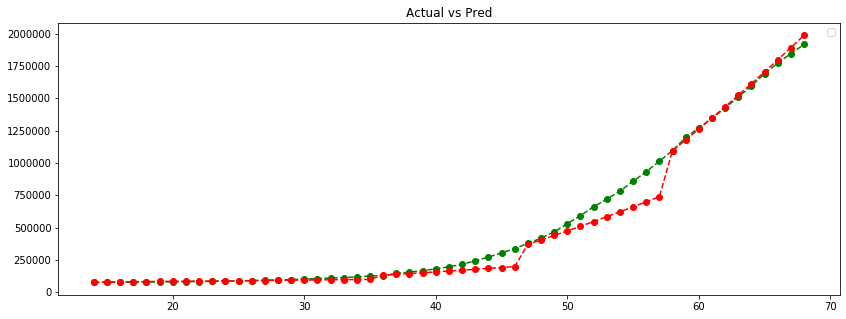

In [125]:
fig, ax = plt.subplots(figsize=(14, 5))
y_preds_arima_plot = [y for x in y_preds_arima for y in x]
yplot = y[first_test_ind:]
ax.plot(yplot, 'go--')
ax.plot(pd.Series(y_preds_arima_plot, index = yplot.index), 'ro--')

plt.title('Actual vs Pred')
plt.legend()
plt.show()

### FB Prophet Modeling

In [48]:
df_fb_prophet = mlr_global_df_use[['Date','Confirmed']]
df_fb_prophet.rename(columns={'Date':'ds','Confirmed':'y'},inplace=True)
df_fb_prophet['ds']=df_fb_prophet['ds'].apply(lambda x: x.date())

C:\Users\pspat\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
num_in_test = 7
test_size = float(num_in_test) / len(X)
n_splits = int((1//test_size)-1)
tscv = TimeSeriesSplit(n_splits=n_splits)

y_preds_prophet = []
mapes_prophet =  []
first_test_ind=500000
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    if test_index[0] < first_test_ind:
        first_test_ind=test_index[0]
    df_train = df_fb_prophet.iloc[train_index]
    print(len(df_train))
    prophet_model=Prophet()
    prophet_model.fit(df_train)
    future = prophet_model.make_future_dataframe(periods=7)
    forecast = prophet_model.predict(future)
    forecast=forecast[-7:]
    y_pred = forecast['yhat'].values
    y_test = df_fb_prophet.iloc[test_index]['y']
    y_preds_prophet.append(np.round(y_pred))
    mapes_prophet.append(round((abs((y_pred -y_test) / y_test) * 100).mean()))
    

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
13


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
20


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
27


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
34


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
41


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54]
48


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] TEST: [55 56 57 58 59 60 61]
55


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61] TEST: [62 63 64 65 66 67 68]
62


In [50]:
np.mean(mapes_prophet)

17.25

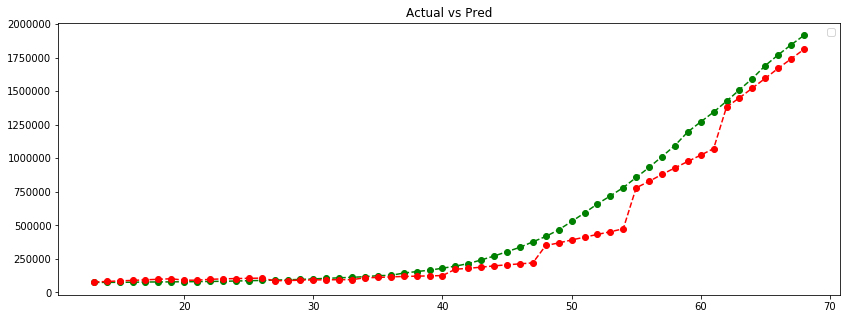

In [51]:
fig, ax = plt.subplots(figsize=(14, 5))
y_preds_prophet_plot = [y for x in y_preds_prophet for y in x]
yplot = y[first_test_ind:]
ax.plot(yplot, 'go--')
ax.plot(pd.Series(y_preds_prophet_plot, index = yplot.index), 'ro--')

plt.title('Actual vs Pred')
plt.legend()
plt.show()